In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import auc, precision_recall_curve, roc_curve, log_loss
from sklearn.svm import SVC
# import pandas as pd


def not_that_deep(X, y, sigma=10, loss="mse", seed=0):
    '''
    X: input data
    y: labels
    sigma: sigma value for bump activation
    loss: mse or bce (binary cross entropy, equiv to log loss)
    seed: random seed
    '''
    
    # x = [1, x_1, x_2, ..., x_n]

    X_ = np.vstack((X.shape[0] * [1], X.T)).T
    
    np.random.seed(seed)
    beta = np.random.randn(X_.shape[1])

    def xorloss(beta):
        y_pred = np.exp(-0.5 * np.square(X_.dot(beta) / sigma)) 

        # without smoothing
        # tildy = X_.dot(beta) != 0
        
        if loss == "mse":
            return np.linalg.norm(y - y_pred) ** 2
        elif loss == "bce":
            return log_loss(y, y_pred)
        else:
            return loss(y, y_pred)

    res = minimize(xorloss, beta)

    return res.x


def generate_gaussian_data(total, ratio=0.5, shuffle=True,
                           means=np.array([[1, 1], [-1, -1]]),
                           covs=np.array([[[.2, .1], [.1, .2]], [[.2, .1], [.1, .2]]]),
                          seed=0, seed2=2023):
    
    assert abs(ratio) <= 1
    
    np.random.seed(seed)
    true_data = np.hstack(
        (np.random.multivariate_normal(means[0], covs[0], size=(int(total * ratio))),
         np.ones(int(total * ratio)).reshape(-1, 1)
        )
    )
    
    np.random.seed(seed+seed2)
    fake_data = np.hstack(
        (np.random.multivariate_normal(means[1], covs[1], size=(total - int(total * ratio))),
         np.zeros(total - int(total * ratio)).reshape(-1, 1)
        )
    )
    
    x_all = np.vstack((true_data, fake_data))
    
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(x_all)
    
    return x_all
    

def decision(w, b, x_0):
    """
    The hyperplane is H = {x: <w, x> + b = 0}.
    This function return x[1] given x[0] for x in H
    """
    return - (x_0 * w[0] + b) / w[1]


def evaluate(beta, x_test, y_test, plot=True, model_name="ES"):
    
    
    x_ = np.vstack((x_test.shape[0] * [1], x_test.T)).T
    
    # flip so that positive class has higher value for prediction
    y_pred = -np.abs(x_ @ beta)
    
    fpr, tpr, t = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc = auc(fpr, tpr)
    
    precision, recall, t = precision_recall_curve(y_test, y_pred, pos_label=1)
    pr_auc = auc(recall, precision)
    
    if plot:
        print(model_name)
        
        fig, axs = plt.subplots(nrows=1, ncols=2)

        axs[0].set_title('ROC Curve')
        axs[0].plot(fpr, tpr, 'blue', alpha=0.8,
                 label='AUC = %0.2f' % roc_auc)
        axs[0].legend(loc = 'lower right')
        axs[0].plot([0, 1], [0, 1],'r--')
        axs[0].set_xlim([0, 1])
        axs[0].set_ylim([0, 1])
        axs[0].set_ylabel('True Positive Rate')
        axs[0].set_xlabel('False Positive Rate')

        axs[1].set_title('Precision-Recall Curve')
        axs[1].plot(recall, precision, 'blue', alpha=0.8,
                 label='AUC = %0.2f' % pr_auc)
        axs[1].legend(loc = 'lower right')
        axs[1].axhline(y_test.sum()/len(y_test), linestyle='--', color='r')
        axs[1].set_xlim([0, 1])
        axs[1].set_ylim([0, 1])
        axs[1].set_ylabel('Precision')
        axs[1].set_xlabel('Recall')
        plt.show()
    
    return pr_auc, roc_auc

# Visualization

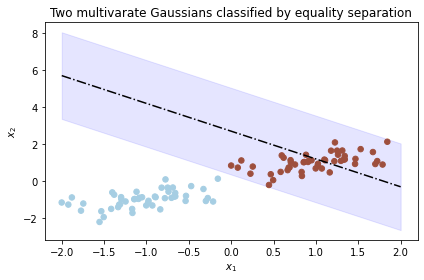

In [2]:
# Symmetric Gaussians 
data = generate_gaussian_data(100, ratio=0.5, shuffle=True, seed=0, seed2=0)
x = data[:, :-1]
y = data[:, -1]

plt.title("Two multivarate Gaussians classified by equality separation")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

plt.scatter(x[:, 0], x[:, 1], c=y, s=30, cmap=plt.cm.Paired)
plt.grid(None)

x_range = [-2, 2]
beta = not_that_deep(x, y)
dec_x = [decision(beta[1:], beta[0], x_) for x_ in x_range]
plt.plot(x_range, dec_x, c="k", linestyle="-.")
plt.fill_between(x_range, 
                 [decision(beta[1:], beta[0]-11, x_) for x_ in x_range],
                 [decision(beta[1:], beta[0]+11, x_) for x_ in x_range],
                alpha=0.1, color='blue')
plt.grid(None)
plt.tight_layout()
plt.show()

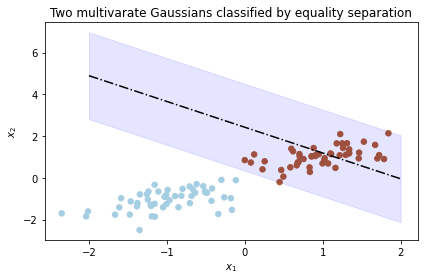

In [3]:
# can try with different seeds
# Non-symmetric Gaussians 

data = generate_gaussian_data(100, ratio=0.5, shuffle=True, seed=0, seed2=2023)
x = data[:, :-1]
y = data[:, -1]

plt.title("Two multivarate Gaussians classified by equality separation")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

plt.scatter(x[:, 0], x[:, 1], c=y, s=30, cmap=plt.cm.Paired)
plt.grid(None)

x_range = [-2, 2]
beta = not_that_deep(x, y)
dec_x = [decision(beta[1:], beta[0], x_) for x_ in x_range]
plt.plot(x_range, dec_x, c="k", linestyle="-.")
plt.fill_between(x_range, 
                 [decision(beta[1:], beta[0]-11, x_) for x_ in x_range],
                 [decision(beta[1:], beta[0]+11, x_) for x_ in x_range],
                alpha=0.1, color='blue')
plt.grid(None)
plt.tight_layout()
plt.show()

In [4]:
def get_results(noise_mult,
                means=np.array([[1, 1], [-1, -1]]),
                cov=np.array([[[.2, .1], [.1, .2]], [[.2, .1], [.1, .2]]]),
                sigmas=[10.], ratio=0.9, num_data=100, repeats=20, loss='mse',
                seed2=2023, plot=True, latex=True, latex_transpose=True):
    
    pr_auc_list_e = [list() for sigma in sigmas]
    roc_auc_list_e = [list() for sigma in sigmas]
    pr_auc_list_s = []
    roc_auc_list_s = []

    
    for noise in noise_mult:
        
#         print(f"Noise Multiplier: {noise}")
        
        prs_e = [list() for sigma in sigmas]
        rocs_e = [list() for sigma in sigmas]
        prs_s = []
        rocs_s = []
        
        for i in range(repeats):
            
            ##### generate data #####################################################
            data = generate_gaussian_data(num_data, ratio=ratio, shuffle=True,
                                          means=means, covs=cov*noise,
                                          seed=i, seed2=seed2)
            X = data[:, :-1] 
            y = data[:, -1]

            data_test = generate_gaussian_data(num_data, ratio=ratio, shuffle=True,
                                               means=means, covs=cov*noise,
                                               seed=i, seed2=seed2)

            x_test = data_test[:, :-1] 
            y_test = data_test[:, -1]
            ##########################################################################

            ##### train SVM ##########################################################
            svm = SVC(kernel='linear', probability=True, class_weight='balanced')
            svm.fit(X, y)

            y_pred = svm.predict_proba(x_test)[:, -1]
            fpr, tpr, t = roc_curve(y_test, y_pred, pos_label=1)
            roc_auc_s = auc(fpr, tpr)
            precision, recall, t = precision_recall_curve(y_test, y_pred, pos_label=1)
            pr_auc_s = auc(recall, precision)
            prs_s.append(pr_auc_s)
            rocs_s.append(roc_auc_s)
            ##########################################################################
            
            ##### train equality separator ###########################################
            for i, sigma in enumerate(sigmas):
                
                beta = not_that_deep(X, y, sigma=sigma, loss=loss, seed=i+42)

                # get metrics
                pr_e, roc_e = evaluate(beta, x_test, y_test, plot=False)

                prs_e[i].append(pr_e)
                rocs_e[i].append(roc_e)
            ##########################################################################

        for i in range(len(sigmas)):
            pr_auc_list_e[i].append(prs_e[i])
            roc_auc_list_e[i].append(rocs_e[i])
            
        pr_auc_list_s.append(prs_s)
        roc_auc_list_s.append(rocs_s)
        
    if plot:
        fig, ax = plt.subplots(1, 1)

        ax.set_title("AUPR against Noise Multiplier")
        ax.set_xlabel("Noise Multiplier")
        ax.set_ylabel("AUPR")

        ax.plot(noise_mult, np.mean(pr_auc_list_s, axis=1), color="black", label="SVM")
        ax.fill_between(noise_mult, 
                        np.mean(pr_auc_list_s, axis=1) - np.std(pr_auc_list_s, axis=1),
                        np.mean(pr_auc_list_s, axis=1) + np.std(pr_auc_list_s, axis=1), 
                        color="black", alpha=0.1)

        for i, sigma in enumerate(sigmas):
            ax.plot(noise_mult, np.mean(pr_auc_list_e[i], axis=1), label=fr"Equality $\sigma={sigma}$")
            ax.fill_between(noise_mult,
                            np.mean(pr_auc_list_e[i], axis=1) - np.std(pr_auc_list_e[i], axis=1),
                            np.mean(pr_auc_list_e[i], axis=1) + np.std(pr_auc_list_e[i], axis=1), 
                            alpha=0.1)

        plt.tight_layout()
        plt.legend()
        plt.show()
    
    if latex:
        # can be used to print LaTeX table
        if not latex_transpose:
            print(r"\hline")
            print("NM", end="")
            for i in range(len(pr_auc_list_s)):
                print(" & ", end="")
                print(noise_mult[i], end="")
            print(r"\\")  
            print(r"\hline")  

            print("SVM", end="")
            for i in range(len(pr_auc_list_s)):
                print(" & ", end="")
                print(f"{np.round(np.mean(pr_auc_list_s, axis=1)[i], 2)}$\\pm${np.round(np.std(pr_auc_list_s, axis=1)[i], 2)}",
                      end="")
            print(r"\\")   

            for j, sigma_results in enumerate(pr_auc_list_e):
                print(f"ES ($\sigma={sigmas[j]}$)", end="")
                for i in range(len(sigma_results)):
                    print(" & ", end="")
                    print(f"{np.round(np.mean(sigma_results, axis=1)[i], 2)}$\\pm${np.round(np.std(sigma_results, axis=1)[i], 2)}",
                          end="")
                print(r"\\")
            print(r"\hline")
        
        else:
            print(r"\hline")
            print("NM", end=" & ")
            print("SVM", end="")
            for sigma in sigmas:
                print(f" & ES ($\sigma={sigma}$)", end="")
            print("\\\\")
            print(r"\hline")
            
            for i in range(len(noise_mult)):
                print(noise_mult[i], end="")
                print(" & ", end="")
                
                # SVM
                print(f"{np.round(np.mean(pr_auc_list_s, axis=1)[i], 2)}$\\pm${np.round(np.std(pr_auc_list_s, axis=1)[i], 2)}",
                      end="")
                print()
                
                # ES
                for j in range(len(sigmas)):
                    print(" & ", end="")
                    print(f"{np.round(np.mean(pr_auc_list_e[j], axis=1)[i], 2)}$\\pm${np.round(np.std(pr_auc_list_e[j], axis=1)[i], 2)}",
                          end="")
                    
                print(r"\\")
            print(r"\hline")
    
    return pr_auc_list_e, roc_auc_list_e, pr_auc_list_s, roc_auc_list_s

# Compare Equality Separators (under MSE) with SVMs

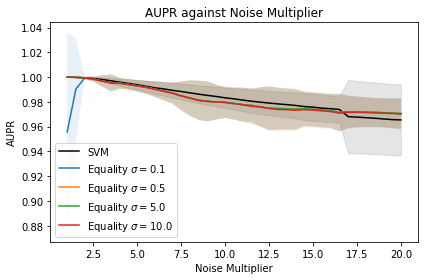

\hline
NM & SVM & ES ($\sigma=0.1$) & ES ($\sigma=0.5$) & ES ($\sigma=5.0$) & ES ($\sigma=10.0$)\\
\hline
1.0 & 1.0$\pm$0.0
 & 0.96$\pm$0.08 & 1.0$\pm$0.0 & 1.0$\pm$0.0 & 1.0$\pm$0.0\\
1.5 & 1.0$\pm$0.0
 & 0.99$\pm$0.04 & 1.0$\pm$0.0 & 1.0$\pm$0.0 & 1.0$\pm$0.0\\
2.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0 & 1.0$\pm$0.0 & 1.0$\pm$0.0 & 1.0$\pm$0.0\\
2.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0 & 1.0$\pm$0.0 & 1.0$\pm$0.0 & 1.0$\pm$0.0\\
3.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0 & 1.0$\pm$0.0 & 1.0$\pm$0.0 & 1.0$\pm$0.0\\
3.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.01 & 1.0$\pm$0.01 & 1.0$\pm$0.01 & 1.0$\pm$0.01\\
4.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0 & 1.0$\pm$0.0 & 1.0$\pm$0.0 & 1.0$\pm$0.0\\
4.5 & 0.99$\pm$0.0
 & 0.99$\pm$0.0 & 0.99$\pm$0.0 & 0.99$\pm$0.0 & 0.99$\pm$0.0\\
5.0 & 0.99$\pm$0.0
 & 0.99$\pm$0.0 & 0.99$\pm$0.0 & 0.99$\pm$0.0 & 0.99$\pm$0.0\\
5.5 & 0.99$\pm$0.0
 & 0.99$\pm$0.01 & 0.99$\pm$0.01 & 0.99$\pm$0.01 & 0.99$\pm$0.01\\
6.0 & 0.99$\pm$0.01
 & 0.99$\pm$0.01 & 0.99$\pm$0.01 & 0.99$\pm$0.01 & 0.99$\pm$0.01\\
6.5 & 0.99

In [5]:
noise_mult = np.arange(2, 41) / 2
sigmas = [0.1, 0.5, 5., 10.]

pr_auc_list_e, roc_auc_list_e, pr_auc_list_s, roc_auc_list_s = get_results(noise_mult, repeats=20, sigmas=sigmas)

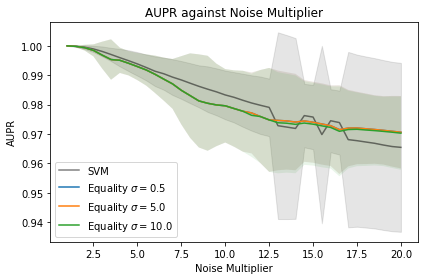

In [6]:
# Remove sigma=0.1 for better plot
fig, ax = plt.subplots(1, 1)

ax.set_title("AUPR against Noise Multiplier")
ax.set_xlabel("Noise Multiplier")
ax.set_ylabel("AUPR")

ax.plot(noise_mult, np.mean(pr_auc_list_s, axis=1), color="black", label="SVM", alpha=0.5)
ax.fill_between(noise_mult, 
                np.mean(pr_auc_list_s, axis=1) - np.std(pr_auc_list_s, axis=1),
                np.mean(pr_auc_list_s, axis=1) + np.std(pr_auc_list_s, axis=1), 
                color="black", alpha=0.1)

for i, sigma in enumerate(sigmas):
    if i == 0:
        continue
    ax.plot(noise_mult, np.mean(pr_auc_list_e[i], axis=1), label=fr"Equality $\sigma={sigma}$")
    ax.fill_between(noise_mult,
                    np.mean(pr_auc_list_e[i], axis=1) - np.std(pr_auc_list_e[i], axis=1),
                    np.mean(pr_auc_list_e[i], axis=1) + np.std(pr_auc_list_e[i], axis=1), 
                    alpha=0.1)

plt.tight_layout()
plt.legend(loc="lower left", bbox_to_anchor=(0,0))
plt.show()

In [7]:
# can be used to print LaTeX table
print(r"\hline")
print("NM", end="")
for i in range(len(pr_auc_list_s)):
    print(" & ", end="")
    print(noise_mult[i], end="")
print(r"\\")  
print(r"\hline")  

print("SVM", end="")
for i in range(len(pr_auc_list_s)):
    print(" & ", end="")
    print(f"{np.round(np.mean(pr_auc_list_s, axis=1)[i], 2)}$\\pm${np.round(np.std(pr_auc_list_s, axis=1)[i], 2)}",
          end="")
print(r"\\")   

for j, sigma_results in enumerate(pr_auc_list_e):
    print(f"ES ($\sigma={sigmas[j]}$)", end="")
    for i in range(len(sigma_results)):
        print(" & ", end="")
        print(f"{np.round(np.mean(sigma_results, axis=1)[i], 2)}$\\pm${np.round(np.std(sigma_results, axis=1)[i], 2)}",
              end="")
    print(r"\\")
print(r"\hline")

\hline
NM & 1.0 & 1.5 & 2.0 & 2.5 & 3.0 & 3.5 & 4.0 & 4.5 & 5.0 & 5.5 & 6.0 & 6.5 & 7.0 & 7.5 & 8.0 & 8.5 & 9.0 & 9.5 & 10.0 & 10.5 & 11.0 & 11.5 & 12.0 & 12.5 & 13.0 & 13.5 & 14.0 & 14.5 & 15.0 & 15.5 & 16.0 & 16.5 & 17.0 & 17.5 & 18.0 & 18.5 & 19.0 & 19.5 & 20.0\\
\hline
SVM & 1.0$\pm$0.0 & 1.0$\pm$0.0 & 1.0$\pm$0.0 & 1.0$\pm$0.0 & 1.0$\pm$0.0 & 1.0$\pm$0.0 & 1.0$\pm$0.0 & 0.99$\pm$0.0 & 0.99$\pm$0.0 & 0.99$\pm$0.0 & 0.99$\pm$0.01 & 0.99$\pm$0.01 & 0.99$\pm$0.01 & 0.99$\pm$0.01 & 0.99$\pm$0.01 & 0.99$\pm$0.01 & 0.99$\pm$0.01 & 0.98$\pm$0.01 & 0.98$\pm$0.01 & 0.98$\pm$0.01 & 0.98$\pm$0.01 & 0.98$\pm$0.01 & 0.98$\pm$0.01 & 0.98$\pm$0.01 & 0.97$\pm$0.03 & 0.97$\pm$0.03 & 0.97$\pm$0.03 & 0.98$\pm$0.01 & 0.98$\pm$0.01 & 0.97$\pm$0.03 & 0.97$\pm$0.01 & 0.97$\pm$0.01 & 0.97$\pm$0.03 & 0.97$\pm$0.03 & 0.97$\pm$0.03 & 0.97$\pm$0.03 & 0.97$\pm$0.03 & 0.97$\pm$0.03 & 0.97$\pm$0.03\\
ES ($\sigma=0.1$) & 0.96$\pm$0.08 & 0.99$\pm$0.04 & 1.0$\pm$0.0 & 1.0$\pm$0.0 & 1.0$\pm$0.0 & 1.0$\pm$0.01 & 1.0$

# Compare Equality Separators (under Log Loss) with SVMs

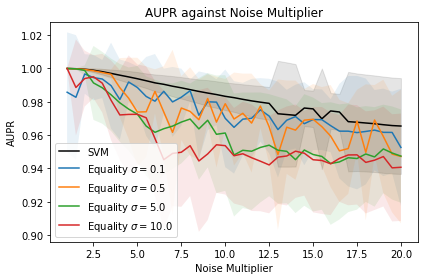

\hline
NM & SVM & ES ($\sigma=0.1$) & ES ($\sigma=0.5$) & ES ($\sigma=5.0$) & ES ($\sigma=10.0$)\\
\hline
1.0 & 1.0$\pm$0.0
 & 0.99$\pm$0.04 & 1.0$\pm$0.0 & 1.0$\pm$0.0 & 1.0$\pm$0.0\\
1.5 & 1.0$\pm$0.0
 & 0.98$\pm$0.04 & 1.0$\pm$0.0 & 1.0$\pm$0.0 & 0.99$\pm$0.03\\
2.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.01 & 1.0$\pm$0.0 & 1.0$\pm$0.0 & 0.99$\pm$0.02\\
2.5 & 1.0$\pm$0.0
 & 0.99$\pm$0.01 & 1.0$\pm$0.0 & 0.99$\pm$0.02 & 1.0$\pm$0.01\\
3.0 & 1.0$\pm$0.0
 & 0.99$\pm$0.01 & 1.0$\pm$0.0 & 0.99$\pm$0.02 & 0.99$\pm$0.02\\
3.5 & 1.0$\pm$0.0
 & 0.99$\pm$0.03 & 1.0$\pm$0.0 & 0.98$\pm$0.02 & 0.98$\pm$0.02\\
4.0 & 1.0$\pm$0.0
 & 0.98$\pm$0.02 & 0.99$\pm$0.02 & 0.98$\pm$0.02 & 0.97$\pm$0.03\\
4.5 & 0.99$\pm$0.0
 & 0.99$\pm$0.01 & 0.98$\pm$0.02 & 0.98$\pm$0.02 & 0.97$\pm$0.04\\
5.0 & 0.99$\pm$0.0
 & 0.99$\pm$0.01 & 0.97$\pm$0.03 & 0.97$\pm$0.03 & 0.97$\pm$0.03\\
5.5 & 0.99$\pm$0.0
 & 0.98$\pm$0.02 & 0.97$\pm$0.03 & 0.97$\pm$0.03 & 0.97$\pm$0.03\\
6.0 & 0.99$\pm$0.01
 & 0.98$\pm$0.03 & 0.99$\pm$0.01 & 0.96$\pm

In [8]:
noise_mult = np.arange(2, 41) / 2
sigmas = [0.1, 0.5, 5., 10.]

pr_auc_list_e, roc_auc_list_e, pr_auc_list_s, roc_auc_list_s = get_results(noise_mult, repeats=20, sigmas=sigmas, loss='bce')

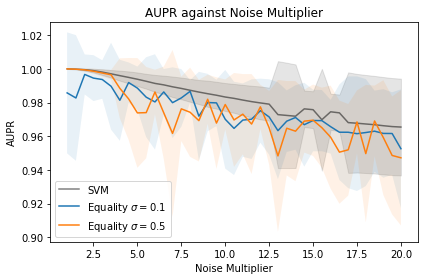

In [9]:
# Remove sigma=10.0, 5.0 for better plot
fig, ax = plt.subplots(1, 1)

ax.set_title("AUPR against Noise Multiplier")
ax.set_xlabel("Noise Multiplier")
ax.set_ylabel("AUPR")

ax.plot(noise_mult, np.mean(pr_auc_list_s, axis=1), color="black", label="SVM", alpha=0.5)
ax.fill_between(noise_mult, 
                np.mean(pr_auc_list_s, axis=1) - np.std(pr_auc_list_s, axis=1),
                np.mean(pr_auc_list_s, axis=1) + np.std(pr_auc_list_s, axis=1), 
                color="black", alpha=0.1)

for i, sigma in enumerate(sigmas):
    if i in [2, 3]:
        continue
    ax.plot(noise_mult, np.mean(pr_auc_list_e[i], axis=1), label=fr"Equality $\sigma={sigma}$")
    ax.fill_between(noise_mult,
                    np.mean(pr_auc_list_e[i], axis=1) - np.std(pr_auc_list_e[i], axis=1),
                    np.mean(pr_auc_list_e[i], axis=1) + np.std(pr_auc_list_e[i], axis=1), 
                    alpha=0.1)

plt.tight_layout()
plt.legend(loc="lower left", bbox_to_anchor=(0,0))
plt.show()

In [10]:
# can be used to print LaTeX table
print(r"\hline")
print("NM", end="")
for i in range(len(pr_auc_list_s)):
    print(" & ", end="")
    print(noise_mult[i], end="")
print(r"\\")  
print(r"\hline")  

print("SVM", end="")
for i in range(len(pr_auc_list_s)):
    print(" & ", end="")
    print(f"{np.round(np.mean(pr_auc_list_s, axis=1)[i], 2)}$\\pm${np.round(np.std(pr_auc_list_s, axis=1)[i], 2)}",
          end="")
print(r"\\")   

for j, sigma_results in enumerate(pr_auc_list_e):
    print(f"ES ($\sigma={sigmas[j]}$)", end="")
    for i in range(len(sigma_results)):
        print(" & ", end="")
        print(f"{np.round(np.mean(sigma_results, axis=1)[i], 2)}$\\pm${np.round(np.std(sigma_results, axis=1)[i], 2)}",
              end="")
    print(r"\\")
print(r"\hline")

\hline
NM & 1.0 & 1.5 & 2.0 & 2.5 & 3.0 & 3.5 & 4.0 & 4.5 & 5.0 & 5.5 & 6.0 & 6.5 & 7.0 & 7.5 & 8.0 & 8.5 & 9.0 & 9.5 & 10.0 & 10.5 & 11.0 & 11.5 & 12.0 & 12.5 & 13.0 & 13.5 & 14.0 & 14.5 & 15.0 & 15.5 & 16.0 & 16.5 & 17.0 & 17.5 & 18.0 & 18.5 & 19.0 & 19.5 & 20.0\\
\hline
SVM & 1.0$\pm$0.0 & 1.0$\pm$0.0 & 1.0$\pm$0.0 & 1.0$\pm$0.0 & 1.0$\pm$0.0 & 1.0$\pm$0.0 & 1.0$\pm$0.0 & 0.99$\pm$0.0 & 0.99$\pm$0.0 & 0.99$\pm$0.0 & 0.99$\pm$0.01 & 0.99$\pm$0.01 & 0.99$\pm$0.01 & 0.99$\pm$0.01 & 0.99$\pm$0.01 & 0.99$\pm$0.01 & 0.99$\pm$0.01 & 0.98$\pm$0.01 & 0.98$\pm$0.01 & 0.98$\pm$0.01 & 0.98$\pm$0.01 & 0.98$\pm$0.01 & 0.98$\pm$0.01 & 0.98$\pm$0.01 & 0.97$\pm$0.03 & 0.97$\pm$0.03 & 0.97$\pm$0.03 & 0.98$\pm$0.01 & 0.98$\pm$0.01 & 0.97$\pm$0.03 & 0.97$\pm$0.01 & 0.97$\pm$0.01 & 0.97$\pm$0.03 & 0.97$\pm$0.03 & 0.97$\pm$0.03 & 0.97$\pm$0.03 & 0.97$\pm$0.03 & 0.97$\pm$0.03 & 0.97$\pm$0.03\\
ES ($\sigma=0.1$) & 0.99$\pm$0.04 & 0.98$\pm$0.04 & 1.0$\pm$0.01 & 0.99$\pm$0.01 & 0.99$\pm$0.01 & 0.99$\pm$0.03 

# Higher Dimensions

## MSE Optimization (with $\sigma=10$)

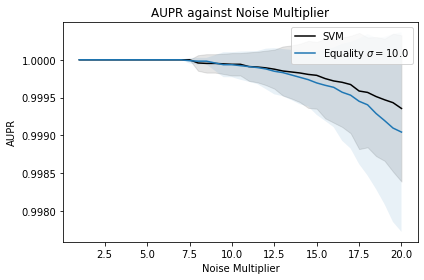

\hline
NM & SVM & ES ($\sigma=10.0$)\\
\hline
1.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
1.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
2.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
2.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
3.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
3.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
4.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
4.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
5.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
5.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
6.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
6.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
7.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
7.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
8.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
8.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
9.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
9.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
10.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
10.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
11.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
11.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
12.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
12.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
13.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
13.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
14.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\


In [11]:
noise_mult = np.arange(2, 41) / 2
sigmas = [10.]

dim = 5
means = np.vstack([np.ones(dim), -np.ones(dim)])
cov = np.array([np.identity(dim)/10, np.identity(dim)/10])

pr_auc_list_e, roc_auc_list_e, pr_auc_list_s, roc_auc_list_s = \
    get_results(noise_mult,  means=means, cov=cov,
                repeats=20, sigmas=sigmas, transpose=False)

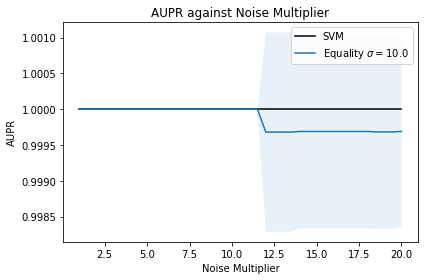

\hline
NM & SVM & ES ($\sigma=10.0$)\\
\hline
1.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
1.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
2.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
2.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
3.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
3.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
4.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
4.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
5.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
5.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
6.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
6.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
7.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
7.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
8.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
8.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
9.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
9.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
10.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
10.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
11.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
11.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
12.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
12.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
13.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
13.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
14.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\


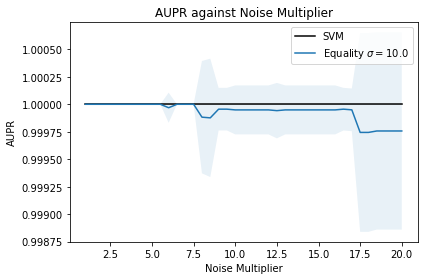

\hline
NM & SVM & ES ($\sigma=10.0$)\\
\hline
1.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
1.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
2.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
2.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
3.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
3.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
4.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
4.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
5.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
5.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
6.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
6.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
7.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
7.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
8.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
8.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
9.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
9.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
10.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
10.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
11.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
11.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
12.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
12.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
13.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
13.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
14.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\


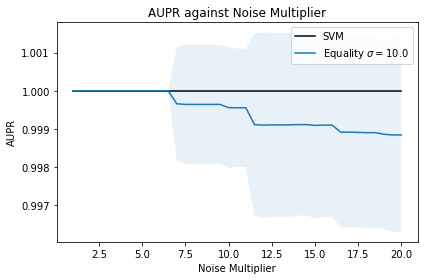

\hline
NM & SVM & ES ($\sigma=10.0$)\\
\hline
1.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
1.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
2.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
2.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
3.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
3.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
4.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
4.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
5.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
5.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
6.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
6.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
7.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
7.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
8.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
8.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
9.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
9.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
10.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
10.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
11.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
11.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
12.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
12.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
13.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
13.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
14.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\


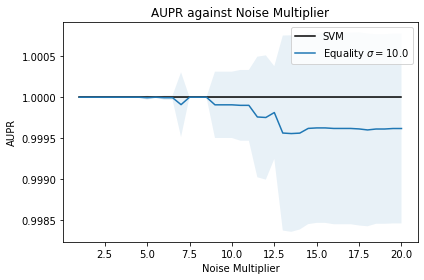

\hline
NM & SVM & ES ($\sigma=10.0$)\\
\hline
1.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
1.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
2.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
2.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
3.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
3.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
4.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
4.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
5.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
5.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
6.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
6.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
7.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
7.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
8.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
8.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
9.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
9.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
10.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
10.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
11.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
11.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
12.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
12.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
13.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
13.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
14.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\


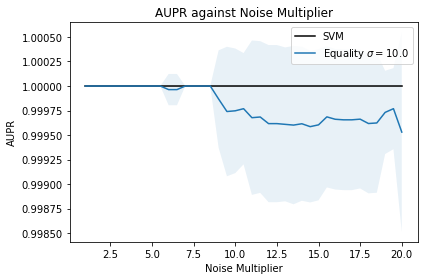

\hline
NM & SVM & ES ($\sigma=10.0$)\\
\hline
1.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
1.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
2.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
2.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
3.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
3.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
4.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
4.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
5.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
5.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
6.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
6.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
7.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
7.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
8.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
8.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
9.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
9.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
10.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
10.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
11.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
11.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
12.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
12.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
13.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
13.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
14.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\


In [12]:
noise_mult = np.arange(2, 41) / 2
sigmas = [10.]

pr_auc_e_dims = []
pr_auc_s_dims = []

for dim in [10, 15, 20, 25, 30]:
    means = np.vstack([np.ones(dim), -np.ones(dim)])
    cov = np.array([np.identity(dim)/10, np.identity(dim)/10])

    pr_auc_list_e, roc_auc_list_e, pr_auc_list_s, roc_auc_list_s = \
        get_results(noise_mult,  means=means, cov=cov,
                    repeats=20, sigmas=sigmas)
    
    pr_auc_e_dims.append(pr_auc_list_e)
    pr_auc_s_dims.append(pr_auc_list_s)

## Log Loss Optimization (with $\sigma=0.5$)

Dimensions: 5


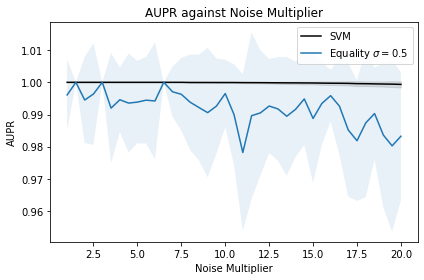

\hline
NM & SVM & ES ($\sigma=0.5$)\\
\hline
1.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.01\\
1.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
2.0 & 1.0$\pm$0.0
 & 0.99$\pm$0.01\\
2.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.02\\
3.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
3.5 & 1.0$\pm$0.0
 & 0.99$\pm$0.02\\
4.0 & 1.0$\pm$0.0
 & 0.99$\pm$0.01\\
4.5 & 1.0$\pm$0.0
 & 0.99$\pm$0.02\\
5.0 & 1.0$\pm$0.0
 & 0.99$\pm$0.01\\
5.5 & 1.0$\pm$0.0
 & 0.99$\pm$0.01\\
6.0 & 1.0$\pm$0.0
 & 0.99$\pm$0.02\\
6.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
7.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.01\\
7.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.01\\
8.0 & 1.0$\pm$0.0
 & 0.99$\pm$0.01\\
8.5 & 1.0$\pm$0.0
 & 0.99$\pm$0.02\\
9.0 & 1.0$\pm$0.0
 & 0.99$\pm$0.02\\
9.5 & 1.0$\pm$0.0
 & 0.99$\pm$0.01\\
10.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.01\\
10.5 & 1.0$\pm$0.0
 & 0.99$\pm$0.02\\
11.0 & 1.0$\pm$0.0
 & 0.98$\pm$0.02\\
11.5 & 1.0$\pm$0.0
 & 0.99$\pm$0.03\\
12.0 & 1.0$\pm$0.0
 & 0.99$\pm$0.02\\
12.5 & 1.0$\pm$0.0
 & 0.99$\pm$0.01\\
13.0 & 1.0$\pm$0.0
 & 0.99$\pm$0.02\\
13.5 & 1.0$\pm$0.0
 & 0.99$\pm$0.0

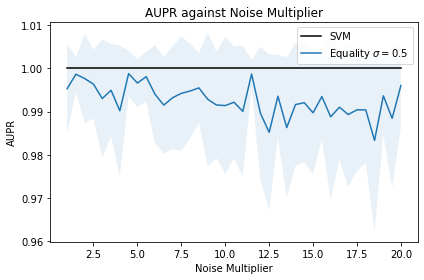

\hline
NM & SVM & ES ($\sigma=0.5$)\\
\hline
1.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.01\\
1.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
2.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.01\\
2.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.01\\
3.0 & 1.0$\pm$0.0
 & 0.99$\pm$0.01\\
3.5 & 1.0$\pm$0.0
 & 0.99$\pm$0.01\\
4.0 & 1.0$\pm$0.0
 & 0.99$\pm$0.02\\
4.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.01\\
5.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.01\\
5.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.01\\
6.0 & 1.0$\pm$0.0
 & 0.99$\pm$0.01\\
6.5 & 1.0$\pm$0.0
 & 0.99$\pm$0.01\\
7.0 & 1.0$\pm$0.0
 & 0.99$\pm$0.01\\
7.5 & 1.0$\pm$0.0
 & 0.99$\pm$0.01\\
8.0 & 1.0$\pm$0.0
 & 0.99$\pm$0.01\\
8.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.01\\
9.0 & 1.0$\pm$0.0
 & 0.99$\pm$0.02\\
9.5 & 1.0$\pm$0.0
 & 0.99$\pm$0.01\\
10.0 & 1.0$\pm$0.0
 & 0.99$\pm$0.02\\
10.5 & 1.0$\pm$0.0
 & 0.99$\pm$0.01\\
11.0 & 1.0$\pm$0.0
 & 0.99$\pm$0.02\\
11.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
12.0 & 1.0$\pm$0.0
 & 0.99$\pm$0.02\\
12.5 & 1.0$\pm$0.0
 & 0.99$\pm$0.02\\
13.0 & 1.0$\pm$0.0
 & 0.99$\pm$0.01\\
13.5 & 1.0$\pm$0.0
 & 0.99$\pm$0.0

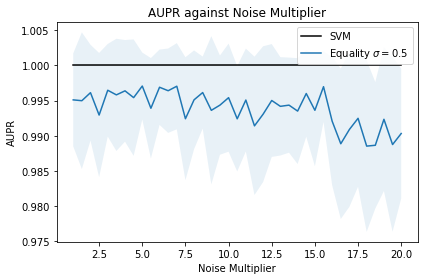

\hline
NM & SVM & ES ($\sigma=0.5$)\\
\hline
1.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.01\\
1.5 & 1.0$\pm$0.0
 & 0.99$\pm$0.01\\
2.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.01\\
2.5 & 1.0$\pm$0.0
 & 0.99$\pm$0.01\\
3.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.01\\
3.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.01\\
4.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.01\\
4.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.01\\
5.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
5.5 & 1.0$\pm$0.0
 & 0.99$\pm$0.01\\
6.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.01\\
6.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.01\\
7.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.01\\
7.5 & 1.0$\pm$0.0
 & 0.99$\pm$0.01\\
8.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.01\\
8.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.01\\
9.0 & 1.0$\pm$0.0
 & 0.99$\pm$0.01\\
9.5 & 1.0$\pm$0.0
 & 0.99$\pm$0.01\\
10.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.01\\
10.5 & 1.0$\pm$0.0
 & 0.99$\pm$0.01\\
11.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.01\\
11.5 & 1.0$\pm$0.0
 & 0.99$\pm$0.01\\
12.0 & 1.0$\pm$0.0
 & 0.99$\pm$0.01\\
12.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.01\\
13.0 & 1.0$\pm$0.0
 & 0.99$\pm$0.01\\
13.5 & 1.0$\pm$0.0
 & 0.99$\pm$0.01\\
1

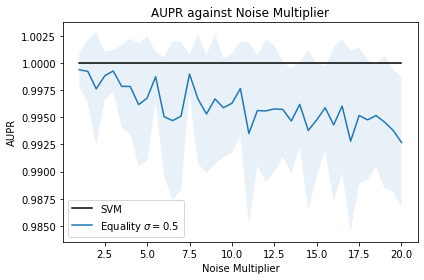

\hline
NM & SVM & ES ($\sigma=0.5$)\\
\hline
1.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
1.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
2.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.01\\
2.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
3.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
3.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
4.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
4.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.01\\
5.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.01\\
5.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
6.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.01\\
6.5 & 1.0$\pm$0.0
 & 0.99$\pm$0.01\\
7.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.01\\
7.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
8.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.01\\
8.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.01\\
9.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.01\\
9.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
10.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
10.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
11.0 & 1.0$\pm$0.0
 & 0.99$\pm$0.01\\
11.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.01\\
12.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.01\\
12.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.01\\
13.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
13.5 & 1.0$\pm$0.0
 & 0.99$\pm$0.0\\
14.0 & 1.0$\pm$0.0
 &

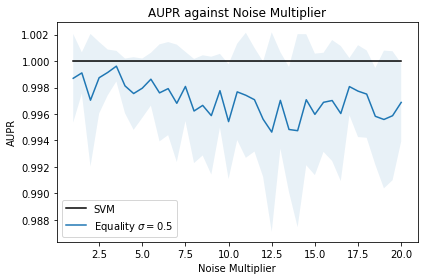

\hline
NM & SVM & ES ($\sigma=0.5$)\\
\hline
1.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
1.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
2.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.01\\
2.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
3.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
3.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
4.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
4.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
5.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
5.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
6.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
6.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
7.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
7.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
8.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
8.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
9.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
9.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
10.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
10.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
11.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
11.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
12.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
12.5 & 1.0$\pm$0.0
 & 0.99$\pm$0.01\\
13.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
13.5 & 1.0$\pm$0.0
 & 0.99$\pm$0.0\\
14.0 & 1.0$\pm$0.0
 & 0.99$\pm$0.

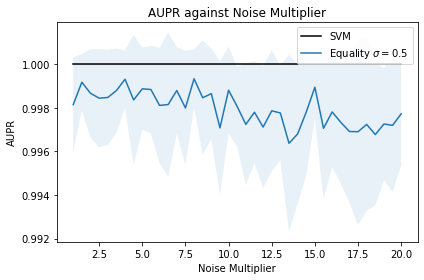

\hline
NM & SVM & ES ($\sigma=0.5$)\\
\hline
1.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
1.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
2.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
2.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
3.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
3.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
4.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
4.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
5.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
5.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
6.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
6.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
7.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
7.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
8.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
8.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
9.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
9.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
10.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
10.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
11.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
11.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
12.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
12.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
13.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
13.5 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
14.0 & 1.0$\pm$0.0
 & 1.0$\pm$0.0\\
1

In [13]:
noise_mult = np.arange(2, 41) / 2
sigmas = [0.5]

pr_auc_e_dims = []
pr_auc_s_dims = []

for dim in [5, 10, 15, 20, 25, 30]:
    print("Dimensions:", dim)
    means = np.vstack([np.ones(dim), -np.ones(dim)])
    cov = np.array([np.identity(dim)/10, np.identity(dim)/10])

    pr_auc_list_e, roc_auc_list_e, pr_auc_list_s, roc_auc_list_s = \
        get_results(noise_mult,  means=means, cov=cov,
                    repeats=20, sigmas=sigmas, loss='bce')
    
    pr_auc_e_dims.append(pr_auc_list_e)
    pr_auc_s_dims.append(pr_auc_list_s)